# Results
In this notebook we are going to show our analysis done on RateBeer, BeerAdvocate and MatchedBeers datasets. <br><br>
Others important notebooks are in:
- `data/processing/`: here we have all the code needed to process the data and make them into a format suitable for our purposes.
- `data/cleaning`: here we have all the code needed for the very preliminary analysis, data cleaning and data filling. 

The data are firstly processed with the code in the `data/processing/` folder and then cleaned with the code in the `data/cleaning/` folder. Finally, the cleaned data are used in this notebook for the analysis. In the cleaning process we also compute new values and in general we manipolate the data to make them more suitable for our purposes. A detailed analysis of the datasets can be found in the notebooks in this folder. <br><br>
At the end of this notebook we have a final section where we describe the future work that we plan to do in the next milestone.

## Preliminary analysis
In this milestone we focused on performing general analysis of the data, cleaning and understanding to ensure that the data were usable for next milestone. In the next milestone we plan to go in depth with the analysis.

### Import all the required libraries

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
import numpy as np
import tqdm
import os
from src.utils.data_desc import *
from src.utils.matched_dataset import *

## BeerAdvocate

#### Loading the fixed data

In [2]:
df_beers = pl.read_parquet("./data/BeerAdvocate/processed/beers.pq")
df_breweries = pl.read_parquet("./data/BeerAdvocate/processed/breweries.pq")
df_users = pl.read_parquet("./data/BeerAdvocate/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/BeerAdvocate/processed/ratings_no_text.pq")

### Data distribution

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

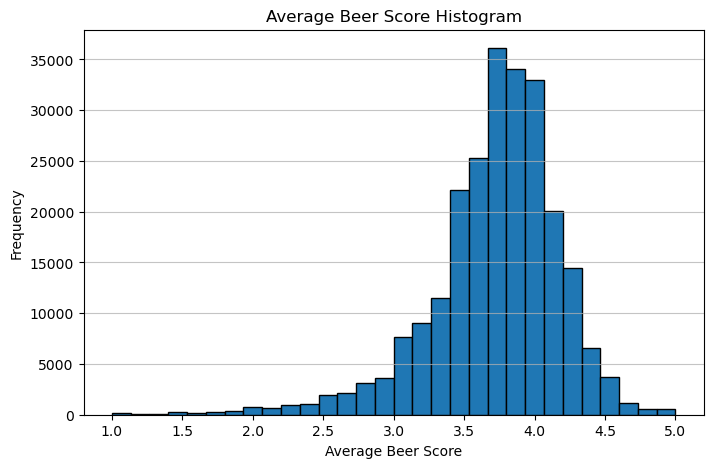

In [3]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Beer Score Histogram')
plt.xlabel('Average Beer Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The average score is normally distributed. Most of the beers get a score in the high threes or the low fours. 

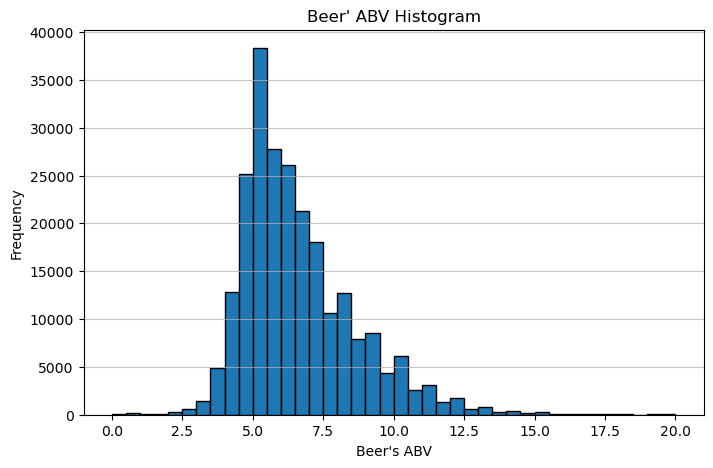

In [4]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('Beer\' ABV Histogram')
plt.xlabel('Beer\'s ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The ABV on the other hand, seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

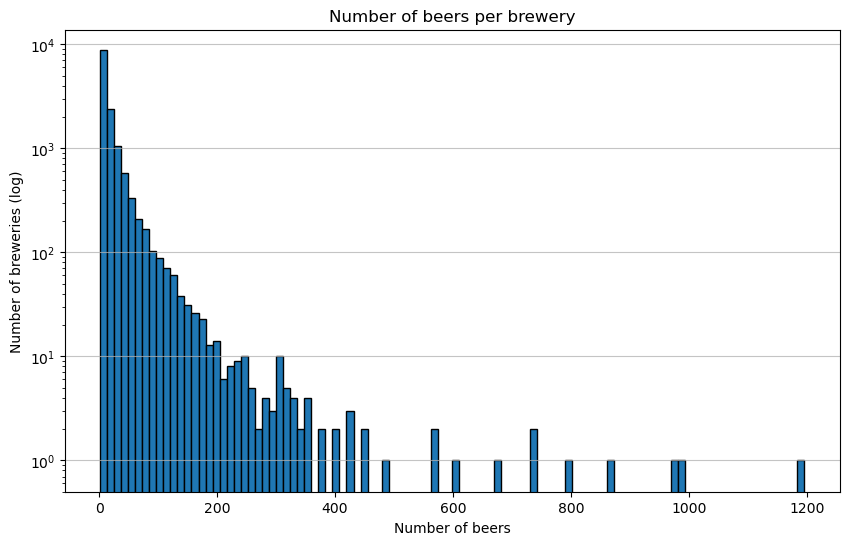

In [5]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

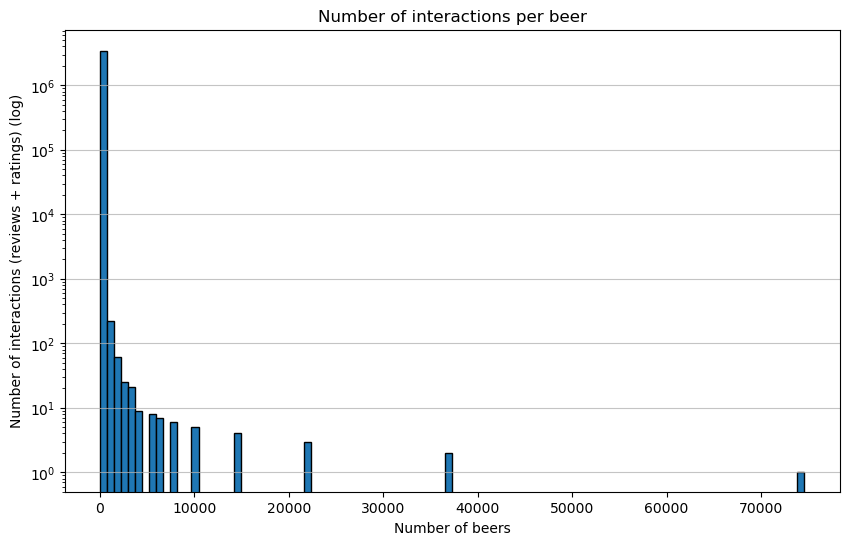

In [6]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_interactions'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(values["nbr_ratings"], bins=100, weights=values["count"], edgecolor='black')
plt.hist(values["count"], bins=100, weights=values["nbr_interactions"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of interactions (reviews + ratings) (log)')
plt.xlabel('Number of beers')
plt.title('Number of interactions per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

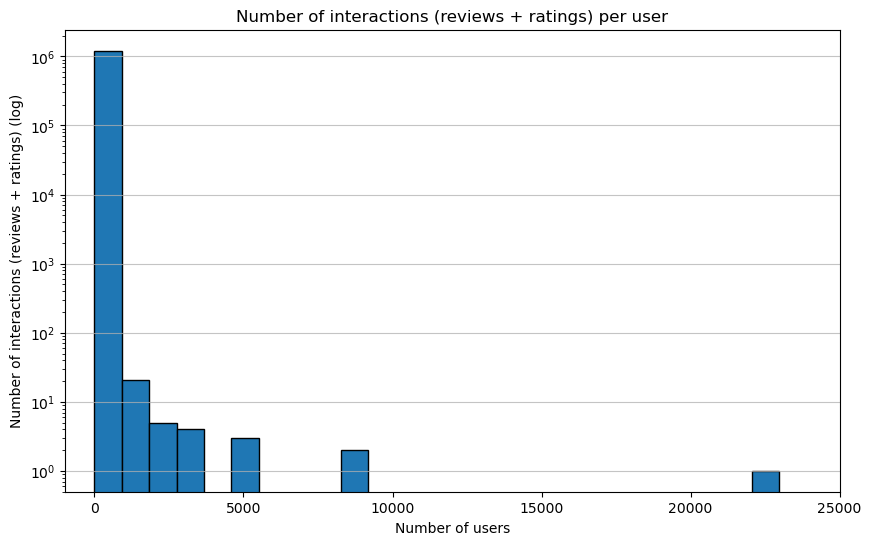

In [7]:
# Plot an histogram with the number of reviews for each user
values = df_users['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of interactions (reviews + ratings) (log)')
plt.xlabel('Number of users')
plt.title('Number of interactions (reviews + ratings) per user')
plt.grid(axis='y', alpha=0.75)
plt.xlim(right=25000)
plt.xlim(left=-1000)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

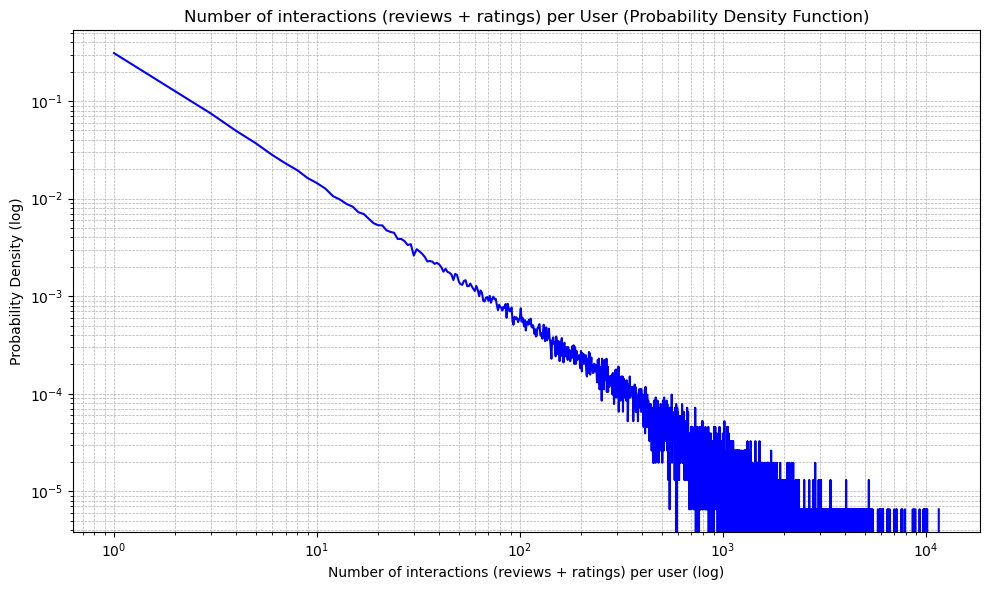

In [8]:
values = df_users['nbr_interactions'].value_counts().to_pandas()

all_ratings = np.arange(values['nbr_interactions'].min(), values['nbr_interactions'].max() + 1)
values = values.set_index('nbr_interactions').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions (reviews + ratings) per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of interactions (reviews + ratings) per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

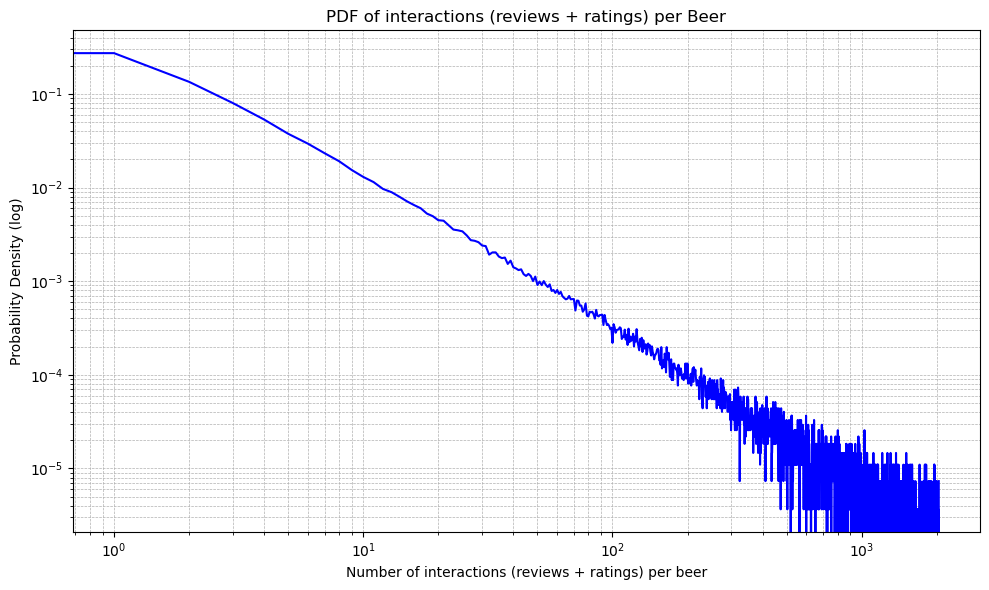

In [9]:
values = df_beers['nbr_interactions'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_interactions').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions (reviews + ratings) per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of interactions (reviews + ratings) per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In these two cases, we indeed see that both plots are close to a straight line, with a lot of noise in the bottom-right corner. This is usual, as we have very few data points here and thus expect a lot of noise. In both cases, we are indeed dealing with a power law. This has some consequences, statistics like the mean, standard deviation, and variance are meaningless and should be avoided. Other metrics like the median should be used instead.

We can see if this holds for our number of beers per brewery as well.

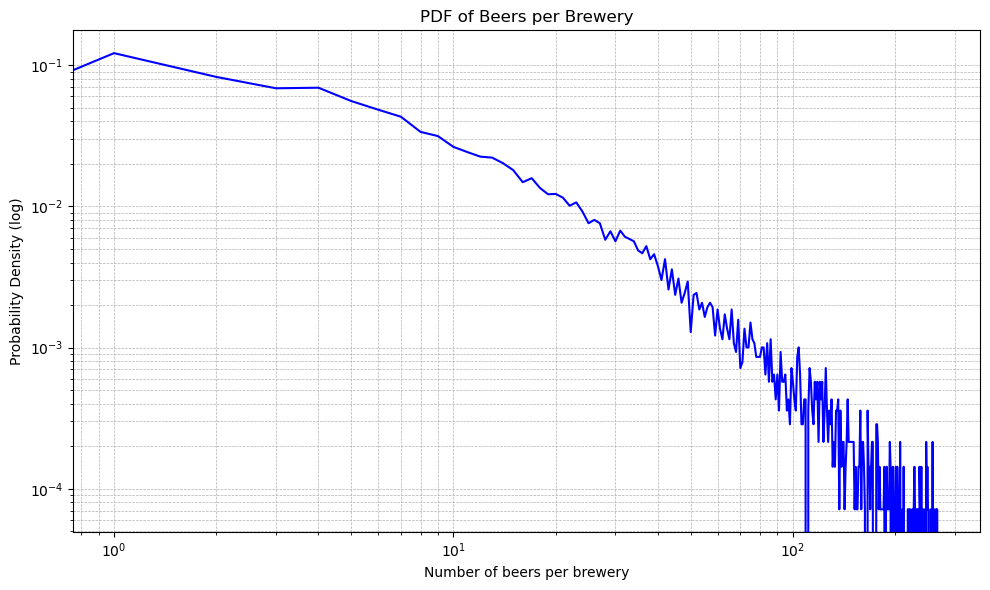

In [10]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

This line is not a straight line. In this case we are therefore not dealing with a power law.

We can now do some initial exploration into potential correlations in our dataframe.

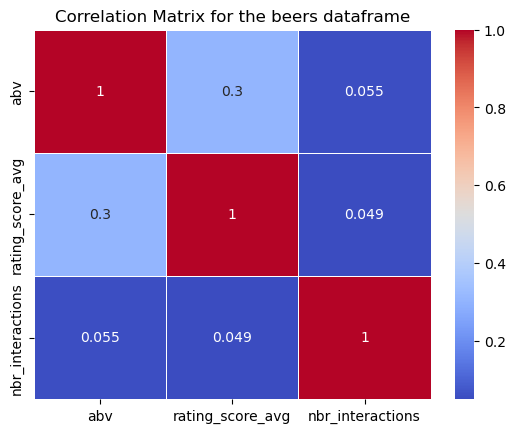

In [11]:
df_beers_corr = df_beers.select(["abv", "rating_score_avg","nbr_interactions"])
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

The correlation between ABV and the average rating is 0.3. This is a relatively weak but definitely noticable correlation. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

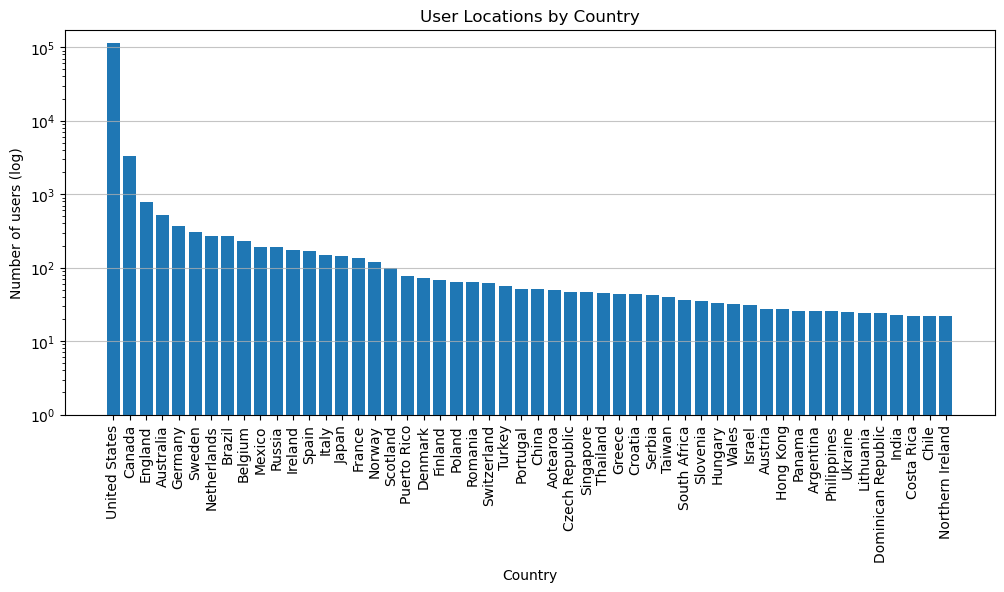

In [12]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

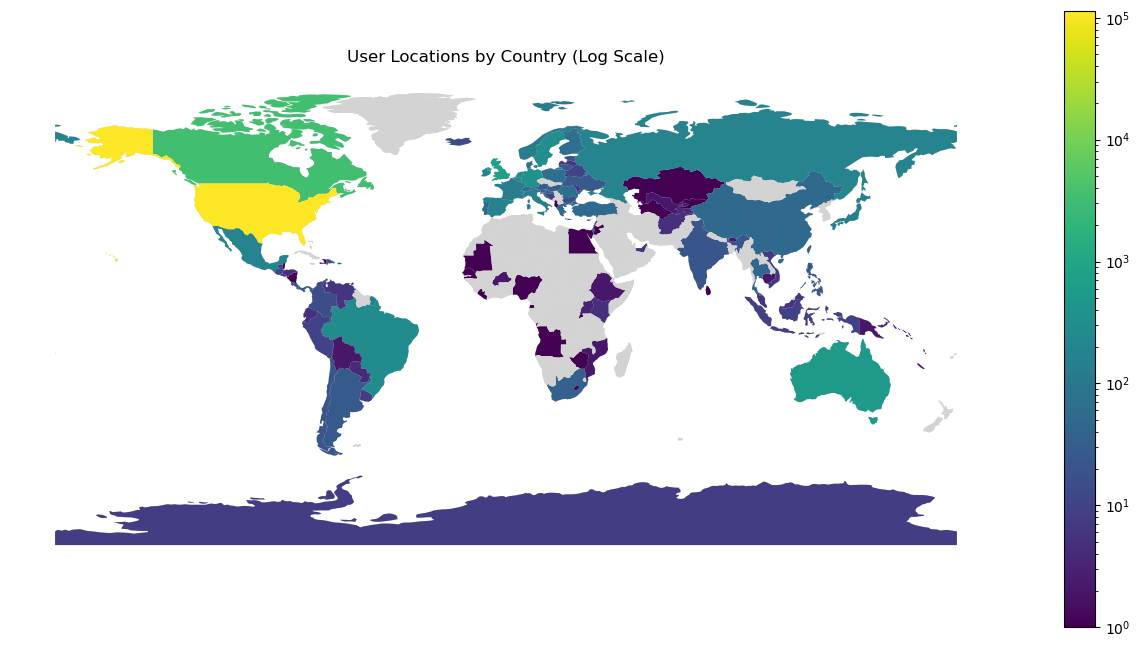

In [13]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

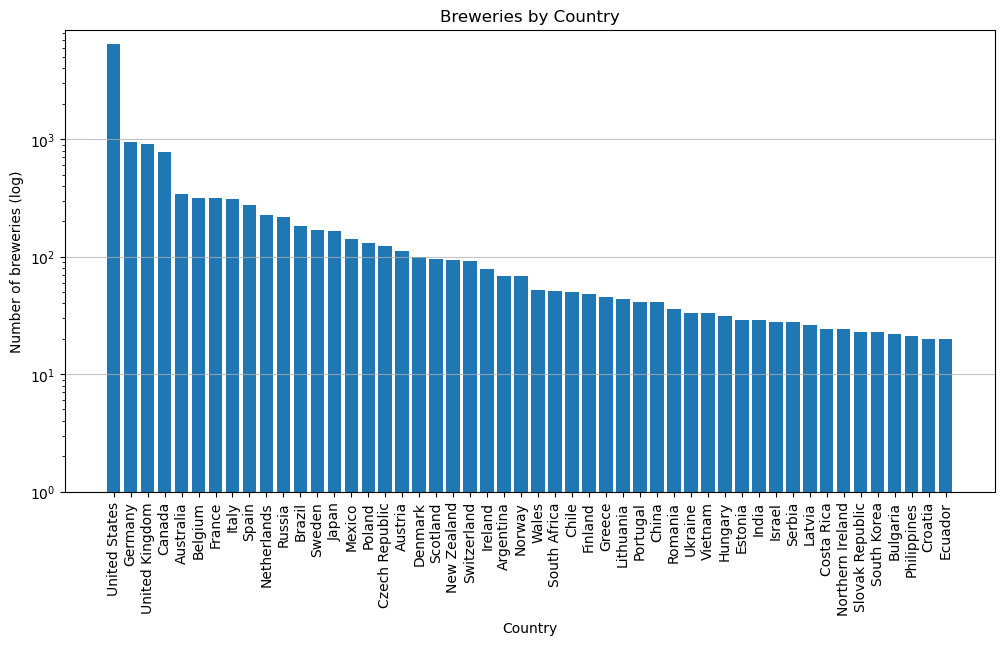

In [14]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

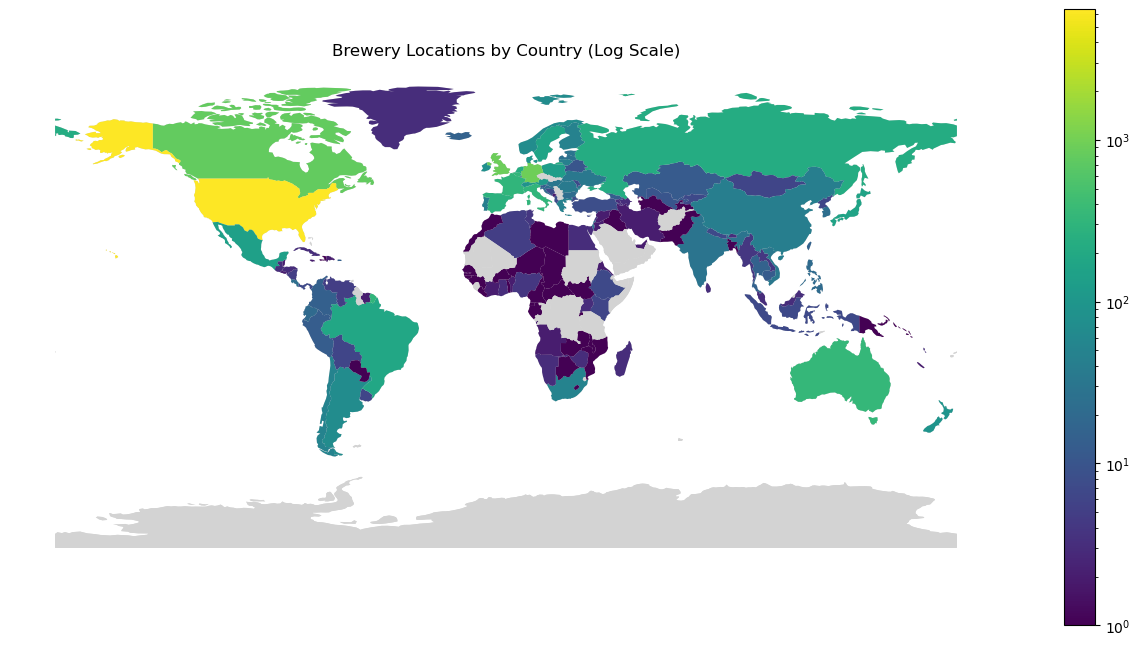

In [15]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Discussion
Given that we have both the information regarding the brewery location and the users location we can link each review with the location of the beer and the origin country of users. 

### Temporal analysis

In this plot we investigate when users joined the website. It is clear to see that the site experiences its peak in 2014. We can also see that our data covers up to the year 2017. 

##### Users join date distribution

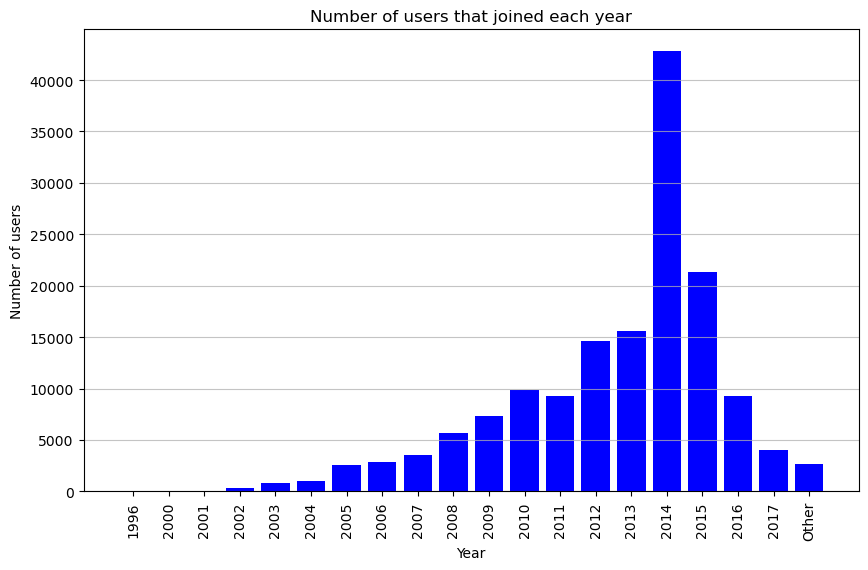

In [16]:
# Plot the number of users that joined each year
values = df_users_pd[df_users_pd['joined'].notna()]['joined'].dt.year.value_counts()

# Convert the index to string
values.index = values.index.astype(str)
values['Other'] = df_users_pd['joined'].isna().sum()

# Sort the values
values = values.sort_index()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(values.index, values.values, color='blue')
plt.xlabel('Year')
plt.xticks(values.index, rotation=90)
plt.ylabel('Number of users')
plt.title('Number of users that joined each year')
plt.grid(axis='y', alpha=0.75)
plt.show()

## RateBeer
#### Data loading

In [17]:
df_beers = pl.read_parquet("./data/RateBeer/processed/beers.pq")
df_breweries = pl.read_parquet("./data/RateBeer/processed/breweries.pq")
df_users = pl.read_parquet("./data/RateBeer/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/RateBeer/processed/ratings_no_text.pq")

#### Data analysis

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

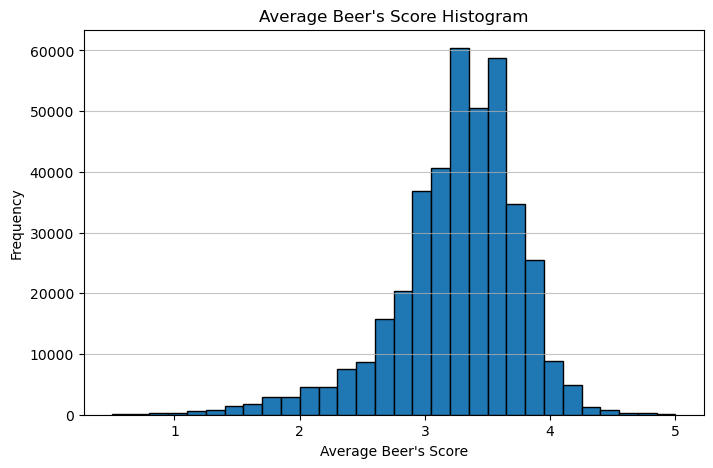

In [18]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Beer\'s Score Histogram')
plt.xlabel('Average Beer\'s Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Here we see that the rating_score_avg seems to resemble a normal distribution. 

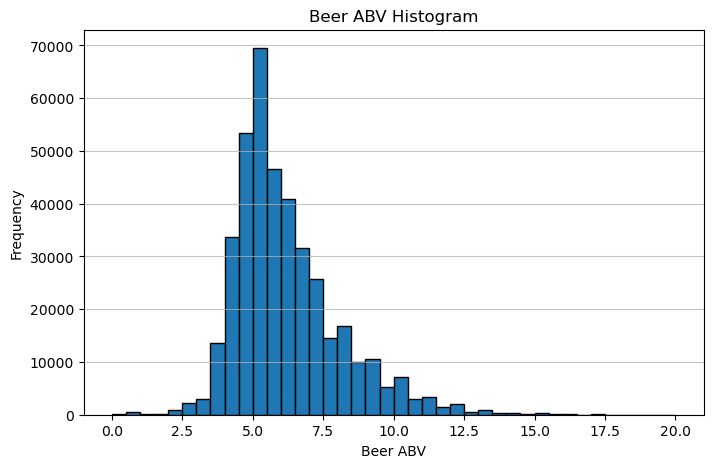

In [19]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('Beer ABV Histogram')
plt.xlabel('Beer ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


Just like in the BeerAdvocate dataset, the ABV seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

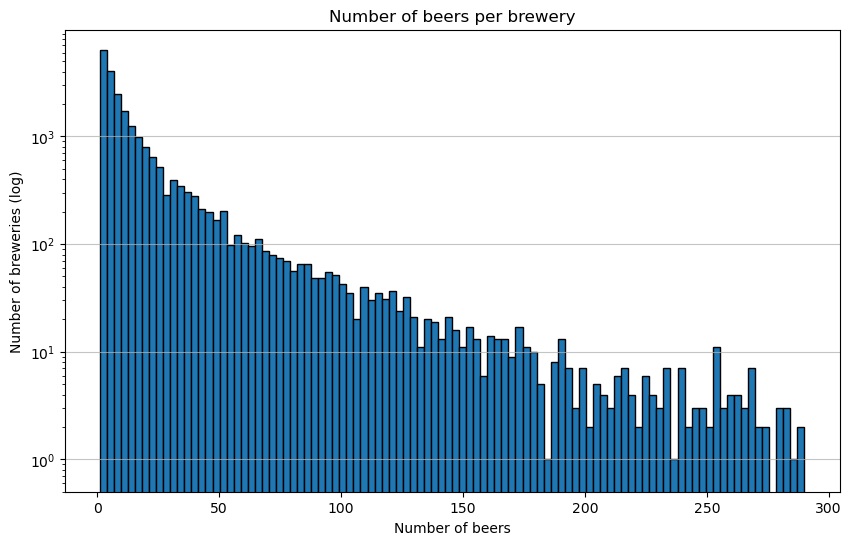

In [20]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

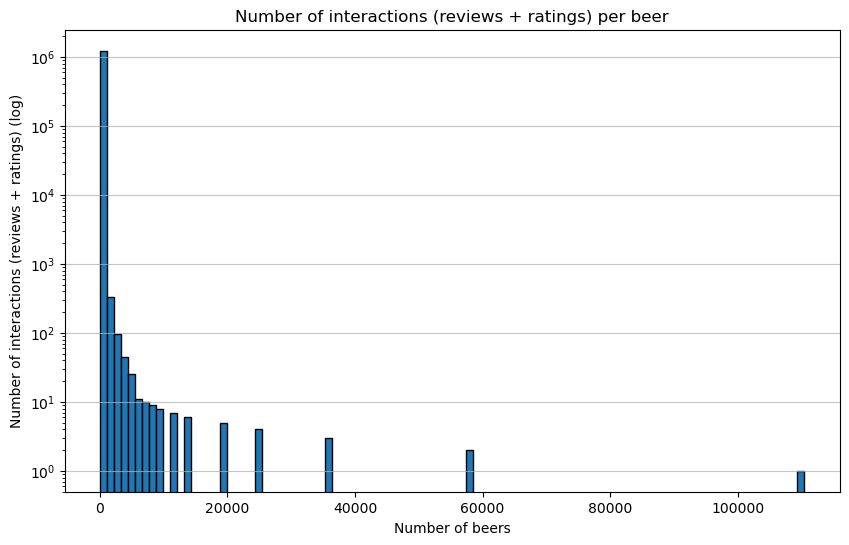

In [21]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_interactions'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["nbr_interactions"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of interactions (reviews + ratings) (log)')
plt.xlabel('Number of beers')
plt.title('Number of interactions (reviews + ratings) per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

/tmp/ipykernel_54268/4098106632.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


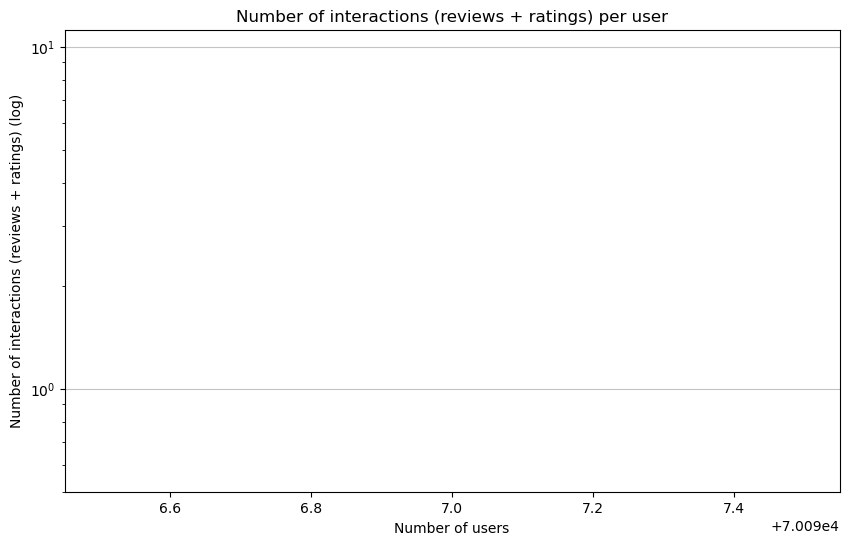

In [22]:
# Plot an histogram with the number of reviews for each user
values = df_users['nbr_interactions'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["nbr_interactions"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of interactions (reviews + ratings) (log)')
plt.xlabel('Number of users')
plt.title('Number of interactions (reviews + ratings) per user')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

/tmp/ipykernel_54268/619459763.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


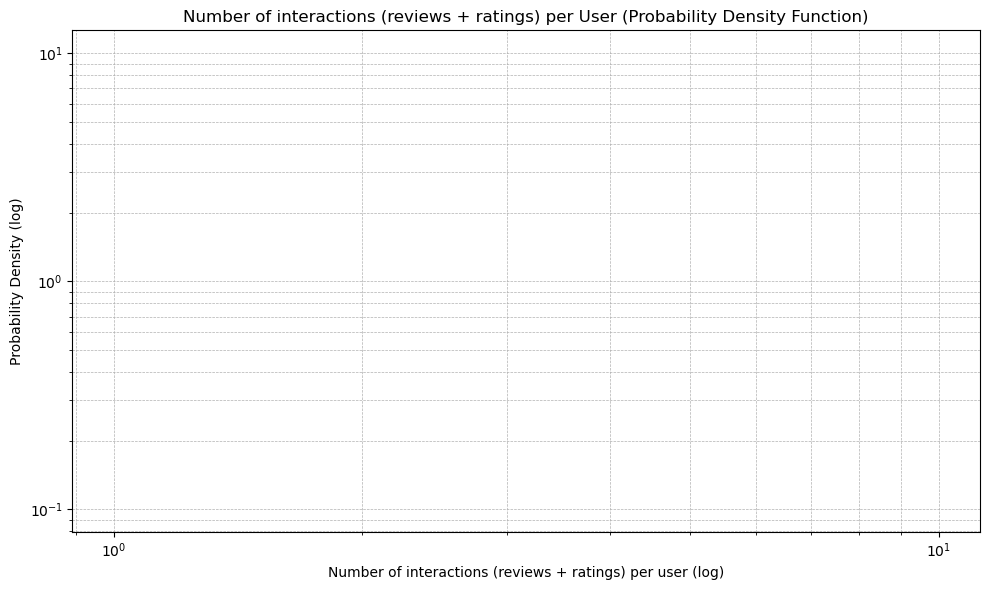

In [23]:
values = df_users['nbr_interactions'].value_counts().to_pandas()

all_ratings = np.arange(values['nbr_interactions'].min(), values['nbr_interactions'].max() + 1)
values = values.set_index('nbr_interactions').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions (reviews + ratings) per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of interactions (reviews + ratings) per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

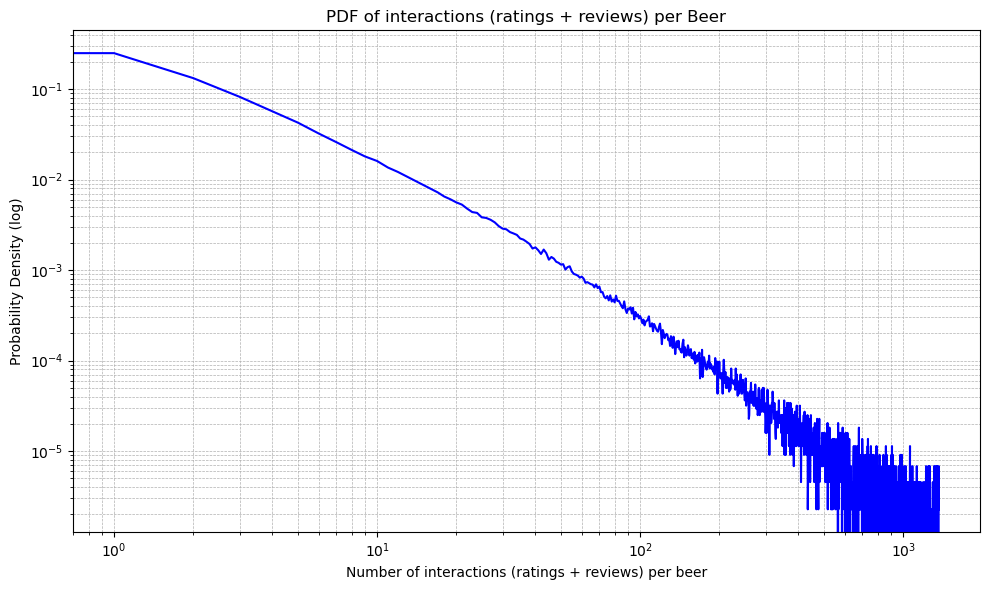

In [24]:
values = df_beers['nbr_interactions'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_interactions').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions (ratings + reviews) per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of interactions (ratings + reviews) per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Here, just like in the BeerAdvocate dataset, these are fairly straight lines, so we are dealing with power laws. This has the same implications holds

But also here we can see that the amount of beers per brewery does not follow a power law.

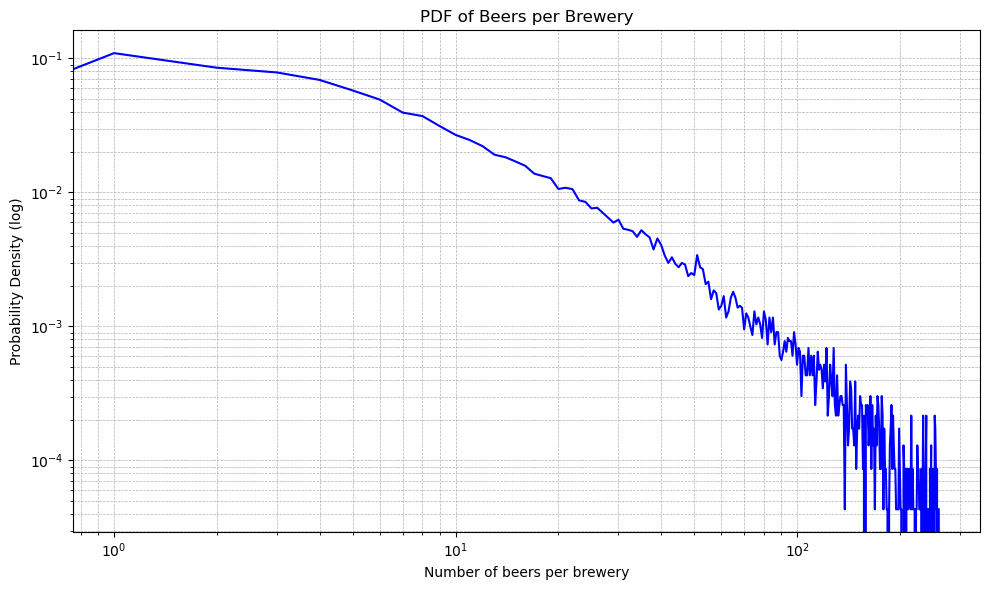

In [25]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

We can now do some initial exploration into potential correlations in our dataframe.

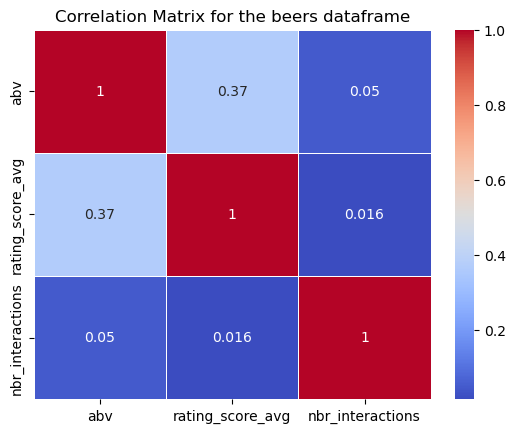

In [26]:
df_beers_corr = df_beers.select([
    'abv', 
    'rating_score_avg', 
    'nbr_interactions', 
])
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()

# plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

Here, just as with BeerAdvocate, we have a similar correlation between ABV and the average rating. This is defined as a weak correlation, but it is still definitely important. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

#### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

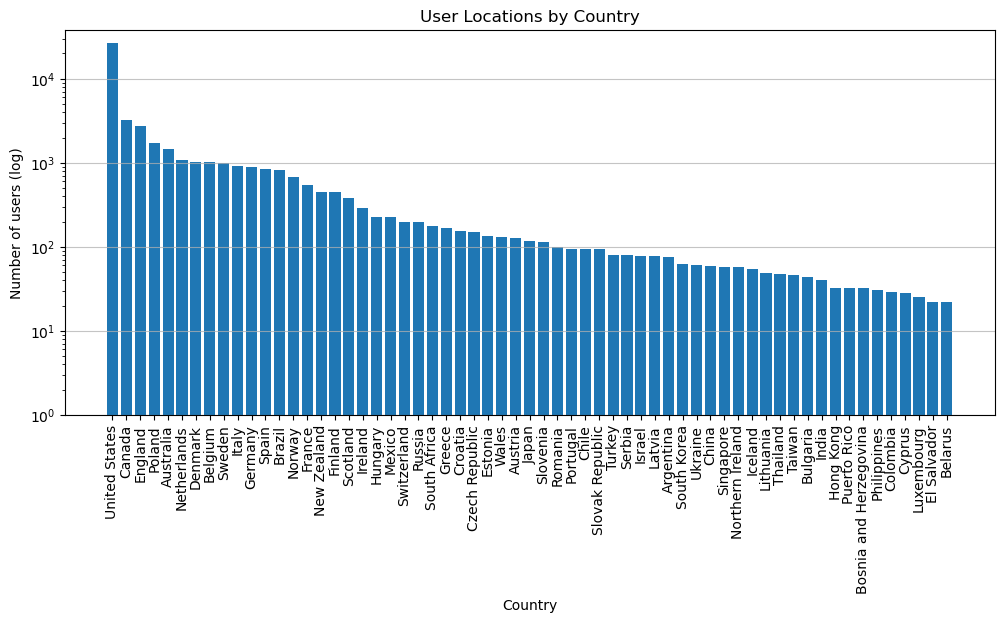

In [27]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

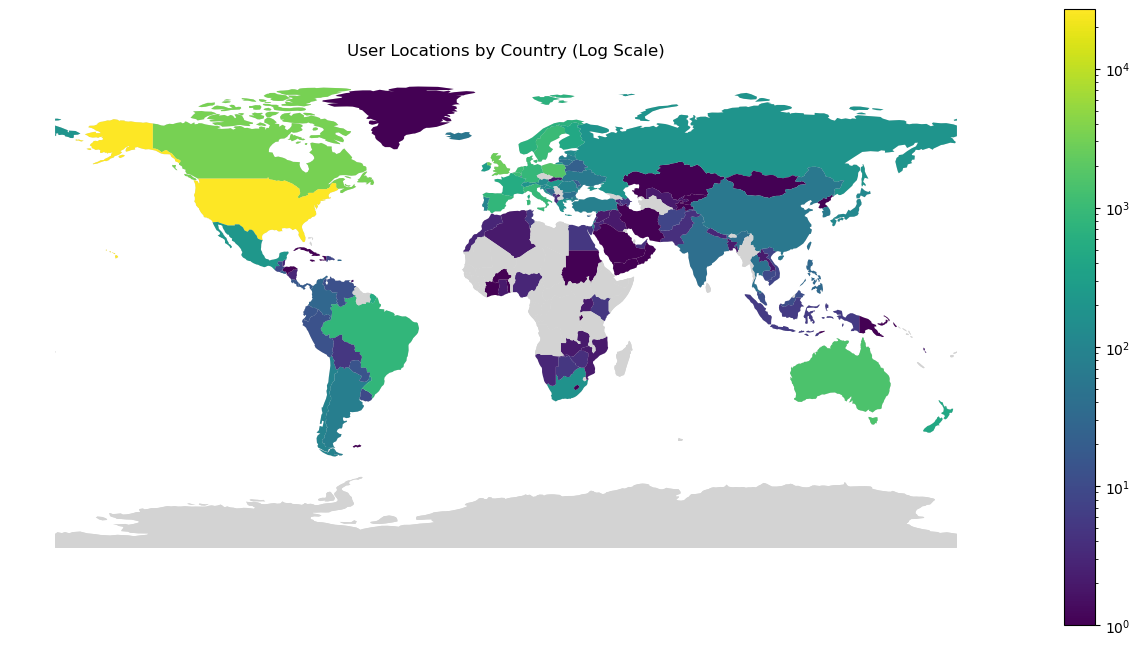

In [28]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

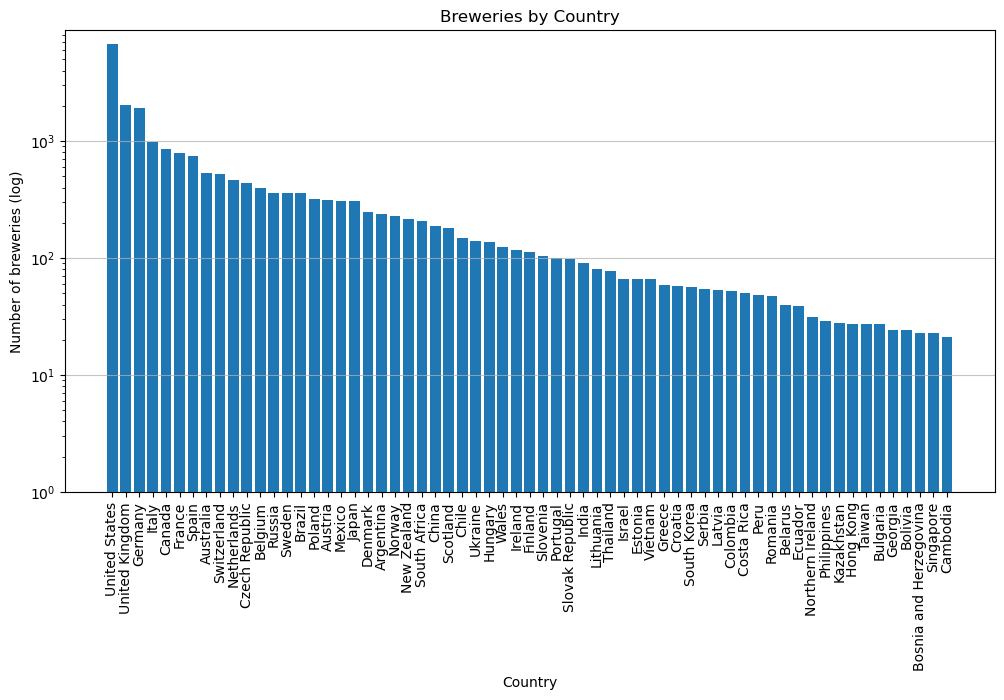

In [29]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

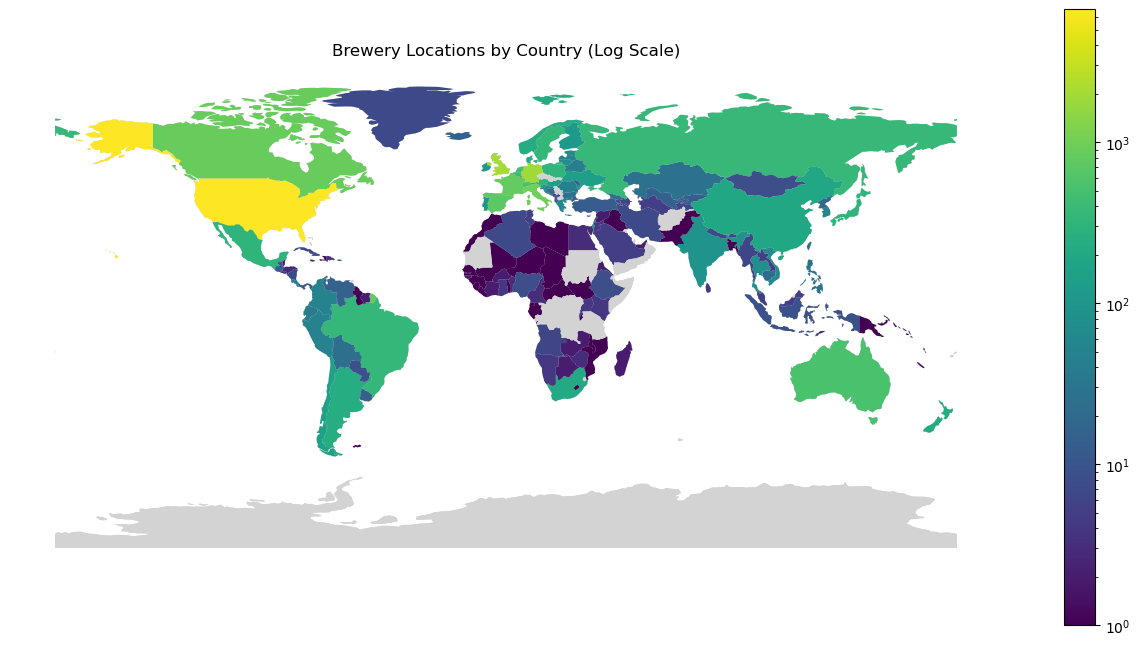

In [30]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

## MatchedBeers

##### Loading the fixed data

In [31]:
path = "./data/MatchedBeer/processed/"

df_beers = pl.read_parquet(path + "beers.pq")
df_breweries = pl.read_parquet(path + "breweries.pq")
df_ratings = pl.read_parquet(path + "ratings.pq")
df_users = pl.read_parquet(path + "users.pq")

#### Data distribuition
Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

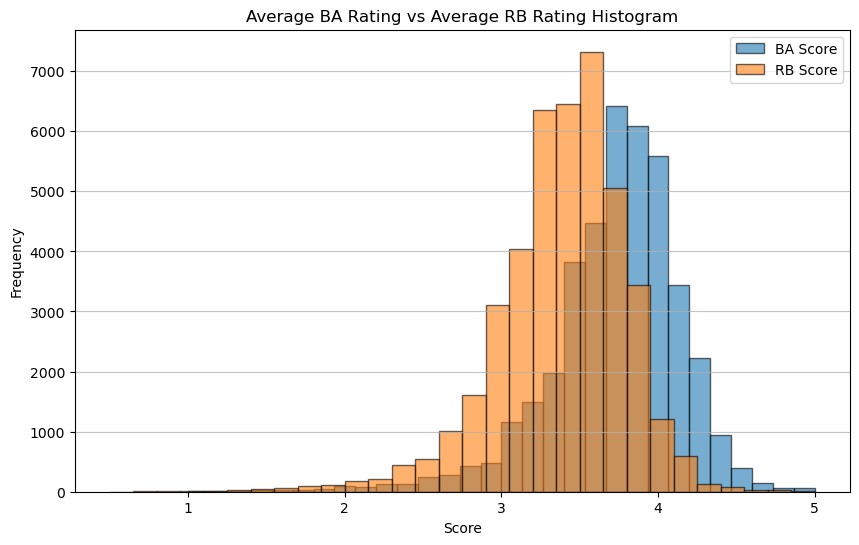

In [32]:
# Extract ba and rb scores as lists, filtering out null values
ba_score = df_beers.select(pl.col("rating_score_avg_ba").filter(pl.col("rating_score_avg_ba").is_not_null())).to_series().to_list()
rb_score = df_beers.select(pl.col("rating_score_avg_rb").filter(pl.col("rating_score_avg_rb").is_not_null())).to_series().to_list()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(ba_score, bins=30, edgecolor='black', alpha=0.6, label='BA Score')
plt.hist(rb_score, bins=30, edgecolor='black', alpha=0.6, label='RB Score')
plt.title('Average BA Rating vs Average RB Rating Histogram')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

Overall Distribution: The BA scores tend to be higher on average than the RB scores. This aligns with previous insights suggesting that BeerAdvocate users generally rate beers more favorably.

Tail Differences: BeerAdvocate has more ratings in the upper range (4 to 5), while RateBeer has very few ratings in that range, reflecting a more conservative or stricter scoring trend on RateBeer.

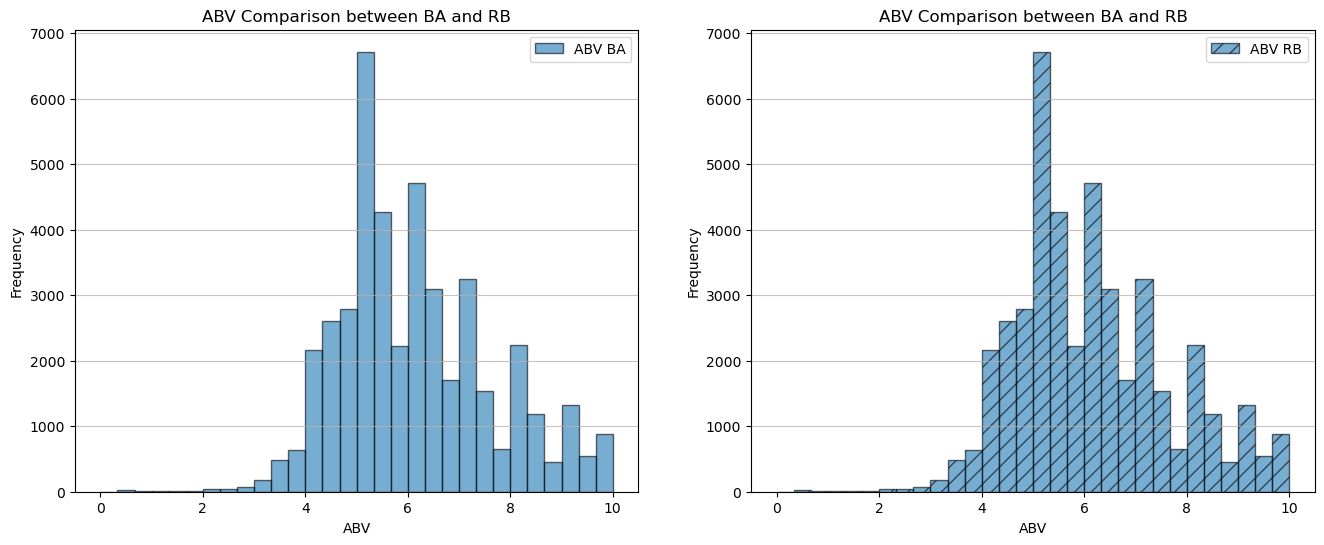

In [33]:
# Extract abv values for ba and rb, filtering out null values
abv_ba = df_beers.select(pl.col("abv_ba").filter(pl.col("abv_ba").is_not_null())).to_series().to_list()
abv_rb = df_beers.select(pl.col("abv_rb").filter(pl.col("abv_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for ABV with hatching pattern on ABV RB
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
# Plot ABV BA with solid fill
plt.hist(abv_ba, bins=30, range=(0, 10), edgecolor='black', alpha=0.6, label='ABV BA')
plt.title('ABV Comparison between BA and RB')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Plot ABV RB with hatching pattern
plt.subplot(1, 2, 2)
plt.hist(abv_rb, bins=30, range=(0, 10), edgecolor='black', alpha=0.6, label='ABV RB', hatch='//')
plt.title('ABV Comparison between BA and RB')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

As expected, the ABV volmue is identical for the two websites. Analysis of this is seen in the notebooks for the individual platforms. 


The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

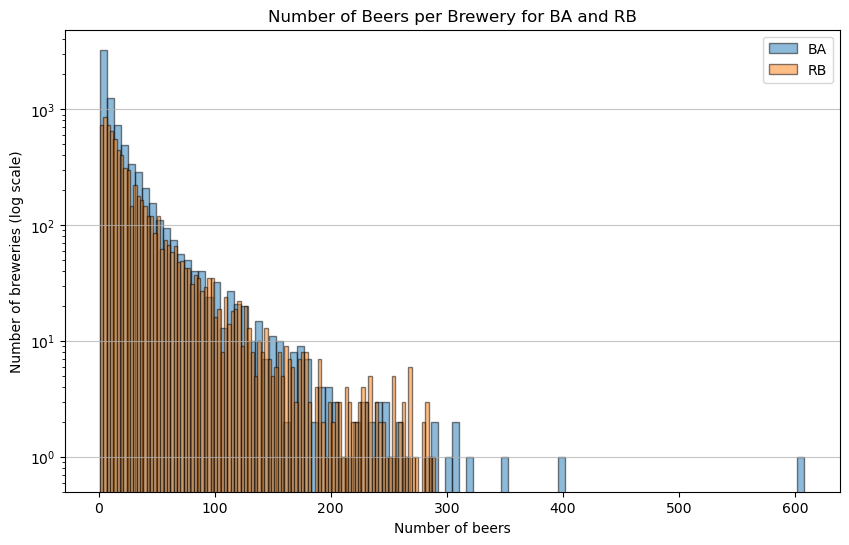

In [34]:
# Extract the number of beers per brewery for BA and RB, filtering out null values
nbr_beers_ba = df_breweries.select(pl.col("beers_count_ba").filter(pl.col("beers_count_ba").is_not_null())).to_series().to_list()
nbr_beers_rb = df_breweries.select(pl.col("beers_count_rb").filter(pl.col("beers_count_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_beers_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_beers_rb, bins=100, edgecolor='black', alpha=0.5, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log scale)')
plt.title('Number of Beers per Brewery for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()


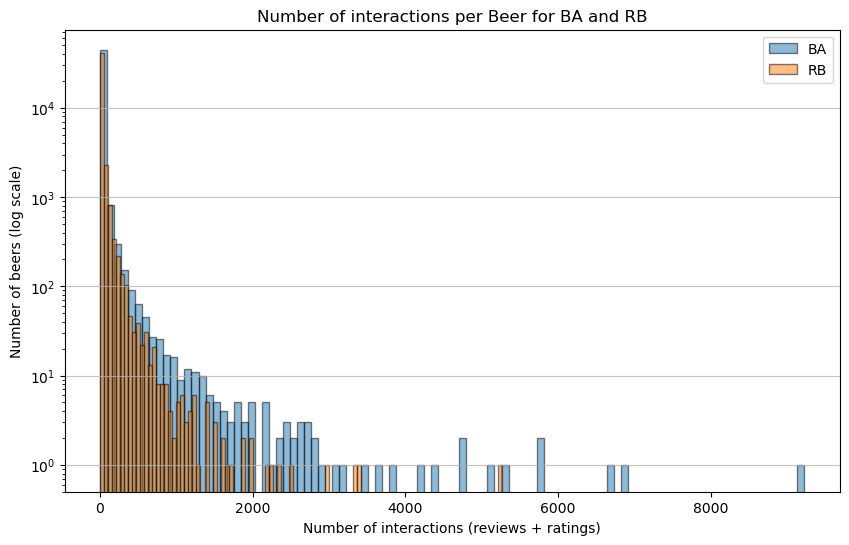

In [35]:
# Extract the number of ratings for BA and RB, filtering out null values
nbr_ratings_ba = df_beers.select(pl.col("nbr_interactions_ba").filter(pl.col("nbr_interactions_ba").is_not_null())).to_series().to_list()
nbr_ratings_rb = df_beers.select(pl.col("nbr_interactions_rb").filter(pl.col("nbr_interactions_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_ratings_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_ratings_rb, bins=100, edgecolor='black', alpha=0.5, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of interactions (reviews + ratings)')
plt.ylabel('Number of beers (log scale)')
plt.title('Number of interactions per Beer for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

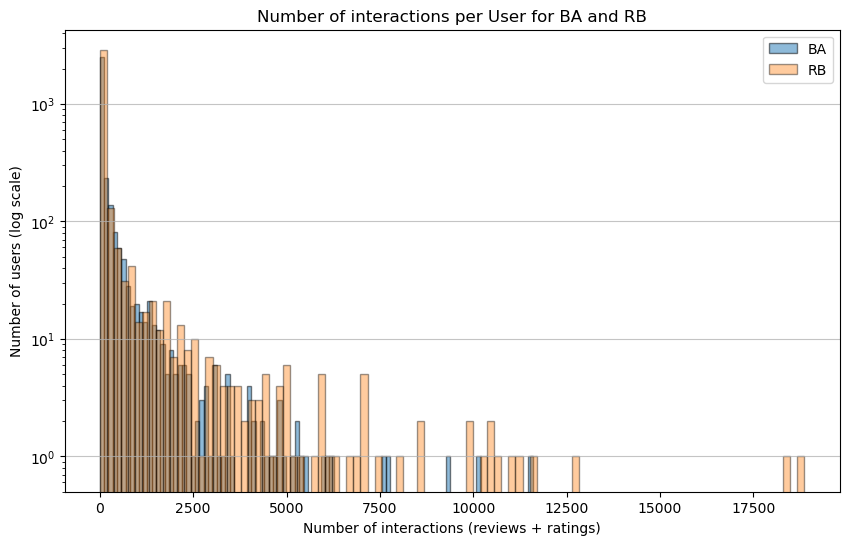

In [36]:
# Extract the number of ratings per user for BA and RB, filtering out null values
nbr_ratings_ba = df_users.select(pl.col("nbr_interactions_ba").filter(pl.col("nbr_interactions_ba").is_not_null())).to_series().to_list()
nbr_ratings_rb = df_users.select(pl.col("nbr_interactions_rb").filter(pl.col("nbr_interactions_rb").is_not_null())).to_series().to_list()

# Plot overlapping histograms for BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for BA with some transparency
plt.hist(nbr_ratings_ba, bins=100, edgecolor='black', alpha=0.5, label='BA', log=True)

# Plot for RB with some transparency
plt.hist(nbr_ratings_rb, bins=100, edgecolor='black', alpha=0.4, label='RB', log=True)

# Adding labels and title
plt.xlabel('Number of interactions (reviews + ratings)')
plt.ylabel('Number of users (log scale)')
plt.title('Number of interactions per User for BA and RB')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

More detail is given earlier for the individual platforms regarding verifying if we are dealing with power laws. In these diagrams we see that the two platforms seem to show a similar trend, so we will take the same approach as earlier and plot as a probability density function on a log-log scale.

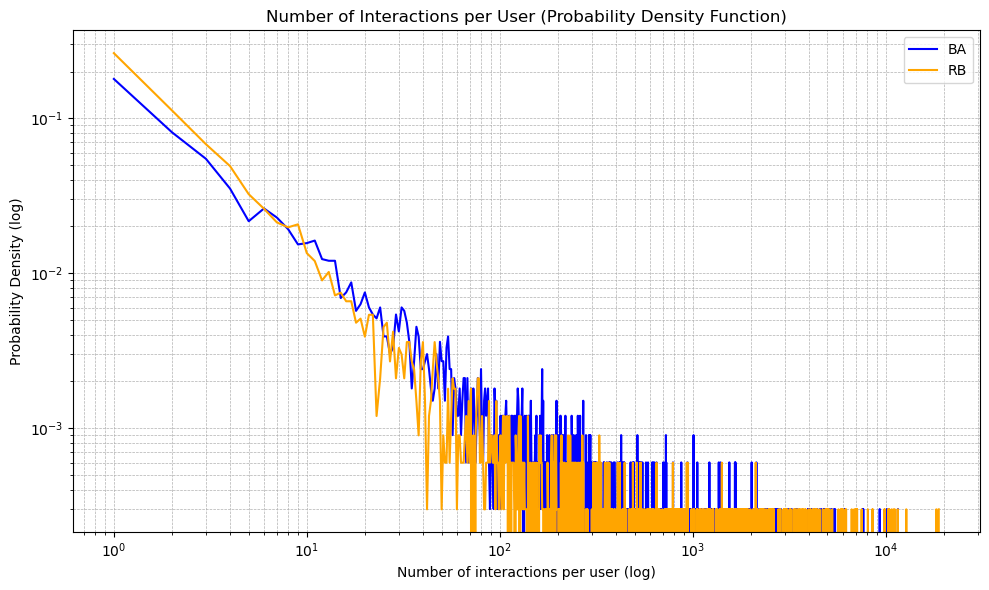

In [37]:
# Count occurrences for 'nbr_interactions_ba' and 'nbr_interactions_rb'
values_ba = df_users.select(pl.col("nbr_interactions_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_interactions', 'count_ba']

values_rb = df_users.select(pl.col("nbr_interactions_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_interactions', 'count_rb']

# Create a complete range of interactions, filling missing counts with 0
all_interactions = np.arange(min(values_ba['nbr_interactions'].min(), values_rb['nbr_interactions'].min()), 
                        max(values_ba['nbr_interactions'].max(), values_rb['nbr_interactions'].max()) + 1)

# Reindex and fill missing values with 0 for both BA and RB
values_ba = values_ba.set_index('nbr_interactions').reindex(all_interactions, fill_value=0).reset_index()
values_ba.columns = ['nbr_interactions', 'count_ba']

values_rb = values_rb.set_index('nbr_interactions').reindex(all_interactions, fill_value=0).reset_index()
values_rb.columns = ['nbr_interactions', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_interactions'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_interactions'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Interactions per User (Probability Density Function)')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

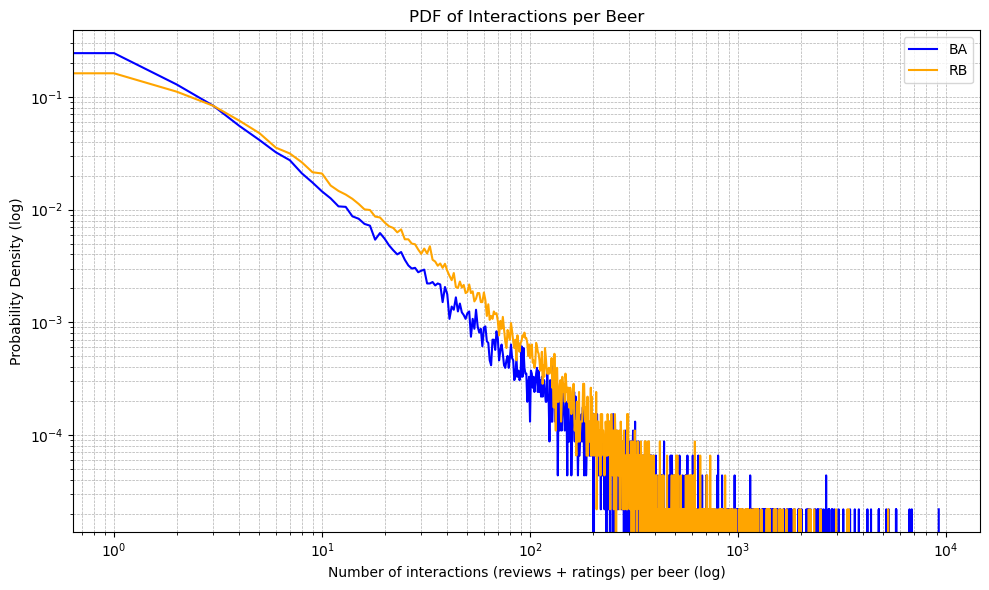

In [38]:
# Count occurrences for 'nbr_interactions_ba' and 'nbr_interactions_rb'
values_ba = df_beers.select(pl.col("nbr_interactions_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_interactions', 'count_ba']

values_rb = df_beers.select(pl.col("nbr_interactions_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_interactions', 'count_rb']

# Define the full range of interactions from min to max across both datasets
all_interactions = np.arange(min(values_ba['nbr_interactions'].min(), values_rb['nbr_interactions'].min()), 
                        max(values_ba['nbr_interactions'].max(), values_rb['nbr_interactions'].max()) + 1)

# Reindex to fill any missing interactions with 0
values_ba = values_ba.set_index('nbr_interactions').reindex(all_interactions, fill_value=0).reset_index()
values_ba.columns = ['nbr_interactions', 'count_ba']

values_rb = values_rb.set_index('nbr_interactions').reindex(all_interactions, fill_value=0).reset_index()
values_rb.columns = ['nbr_interactions', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_interactions'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_interactions'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of interactions (reviews + ratings) per beer (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Interactions per Beer')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In these two diagrams, we indeed see that both plots are close to a straight line, for both platforms, with a lot of noise in the bottom-right corner. This is usual, as we have very few data points here and thus expect a lot of noise. In both cases, we are indeed dealing with a power law. This has some consequences, statistics like the mean, standard deviation, and variance are meaningless and should be avoided. Other metrics like the median should be used instead.

We can see if this holds for our number of beers per brewery for each platform as well.

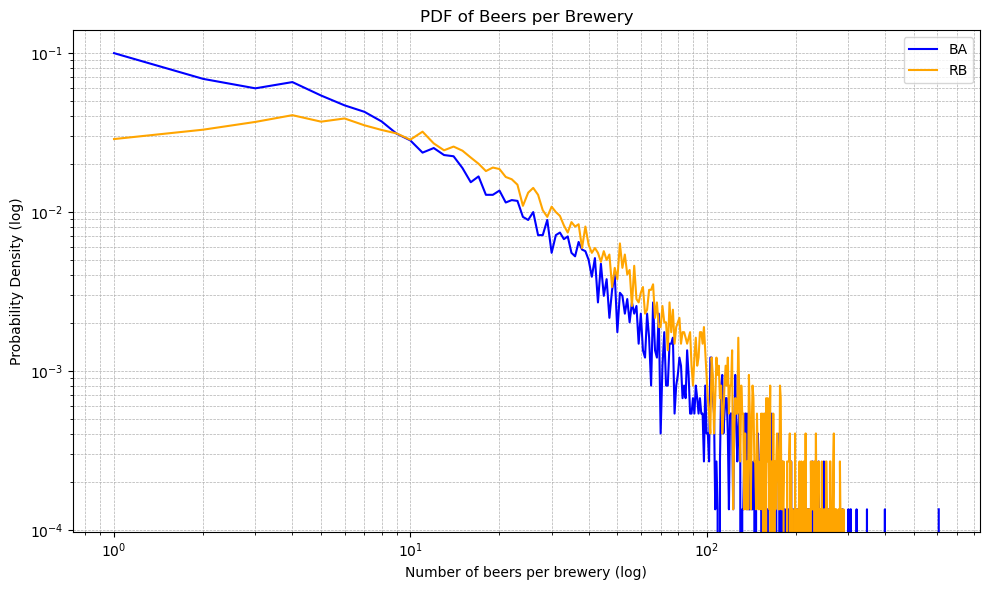

In [39]:
# Count occurrences for 'beers_count_ba' and 'beers_count_rb'
values_ba = df_breweries.select(pl.col("beers_count_ba")).to_series().value_counts().to_pandas()
values_ba.columns = ['nbr_beers', 'count_ba']

values_rb = df_breweries.select(pl.col("beers_count_rb")).to_series().value_counts().to_pandas()
values_rb.columns = ['nbr_beers', 'count_rb']

# Define the full range of beers count from min to max across both datasets
all_counts = np.arange(min(values_ba['nbr_beers'].min(), values_rb['nbr_beers'].min()), 
                       max(values_ba['nbr_beers'].max(), values_rb['nbr_beers'].max()) + 1)

# Reindex to fill any missing beers counts with 0
values_ba = values_ba.set_index('nbr_beers').reindex(all_counts, fill_value=0).reset_index()
values_ba.columns = ['nbr_beers', 'count_ba']

values_rb = values_rb.set_index('nbr_beers').reindex(all_counts, fill_value=0).reset_index()
values_rb.columns = ['nbr_beers', 'count_rb']

# Calculate PDFs as normalized counts
pdf_ba = values_ba['count_ba'] / values_ba['count_ba'].sum()
pdf_rb = values_rb['count_rb'] / values_rb['count_rb'].sum()

# Plotting the PDFs for both BA and RB
fig, ax = plt.subplots(figsize=(10, 6))

# Plot PDF for BA
ax.plot(values_ba['nbr_beers'], pdf_ba, color='blue', label='BA')

# Plot PDF for RB
ax.plot(values_rb['nbr_beers'], pdf_rb, color='orange', label='RB')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

These lines are not straight. In this case, we are therefore not dealing with a power law.

## Future work

Here we'll better describe the mathematical details of the methods we are planning to use. Some of them (mostly the basic ones) have already been used throughout this milestone (mainly for quantitative and statistical analysis). <br>
In the following we'll talk about `popularity` of a beer. What we mean by `popularity` is a beer with a high average rating and a large number of reviews. We will be defining a popularity score as 
$$
\text{Popularity Score} = w_1 \cdot \text{Average Rating} + w_2 \cdot \log(\text{Number of Ratings})
$$
In the next milestone, our goal is to define the coefficients $w_1$ and $w_2$ that we will use to compute this popularity score and explore how changing these values impact our results.
### Quantitative and Statistical Analysis
This section focuses on understanding and exploring the relationships in the data using statistical measures and visualizations. This part, which has already been partially conducted during this milestone to better understand our data, focuses on three main topics:
- <b>Descriptive statistics</b>: We'll focus on studing key metrics of the distributions (such as mean, median, mode, standard deviation, skewness, and kurtosis) to get insights into central tendencies, variability and distributions. We'll use diagrams like histograms and box plots to visualize these key metrics.
- <b>Correlation</b>: We'll focus on understanding correlations within the data to see if some specific variables are strongly correlated with the popularity or quality of a beer. In addition to Pearson correlation we are going to use other methods like Spearman's rank correlation (useful for non-linear relationships) and partial correlation (useful to control for confounders). We'll visualize these results with scatter plots and heatmaps.
- <b>Regression analysis</b>: We'll explore linear regression to predict continuous outcomes (like beer ratings) and logistic regression to estimate categorical outcomes (such as the likelihood of a beer receiving a high rating). We'll use use coefficient plots to help visualize and communicate the results and we'll use methods like R-squared, RSE (for linear regression) and accuracy, precision, and recall (for logistic regression) to assess model fit and prediction accuracy.
### Natural language processing
This section focuses on extracting meaningful insights from the textual data associated with the ratings. The goal is to analyze the reviews of beers to uncover hidden patterns, sentiment and topics that can help us understanding what influences the popularity of a beer. We'll focus on two main topics:
- <b>Frequency analysis</b>: The goal here is to understand if certain words or phrases appear frequently in popular beers and whether there is a correlation between these words and popularity. After preprocessing the reviews to remove punctuations and perform lemmatization we'll calculate the Term Frequency (TF) of each word to measure its occurrence withing a review and the Term Frequency-Inverse Document-Frequency (TF-IDF) to account for the word importance. We'll finally use correlation analysis and statistical tests (such as Chi-Square) to determine whether certain words are significantly associated with higher ratings or more reviews. To visualize and communicate the results we are going to use word clouds and correlation heatmaps.
- <b>Topic Analysis</b>:  The goal here is to uncover hidden thematic structures in the reviews. To achieve this we are going to use Latent Dirichlet Allocation (LDA), an unsupervised learning technique that will help identify topics from the ratings. We'll use this algorithm to extract a fixed number of topics based on word distributions within the reviews. The goal is to see if some topics are associated with high-rated beers, specific beer styles, or ABVs. This will help us undertand if certain topics are more prelevant in some specific countries or time periods.
### Geospatial and temporal analysis
This section focuses on diving into the spatiotemporal patterns of beer preferences and ratings. This is particularly important since it can provide crucial insights into the regional preferences and evolution of beer trends over time. We'll focus on:
- <b>Temporal analysis</b>:
    - <b>Time trend analysis</b>: We will use the Mann-Kendall test to detect monotonic trends in beer preferences over time and we'll explore also methods such as seasonal decomposition of time series or autocorrelation for more particular pattern (e.g. seasonability, cyclicity, etc.). The analysis will consider varying granularities to identify patterns at different time scales. 
    - <b>Event impact</b>: We will assess how major events such as Christmas or Oktokerfest influence beer preferences. This will involves detecting spikes or shift in review volumes or preferences and see how these results compare with our 'World Events' dataset (the dataset created by us that contains the list of some important events globally). This analysis will prioritize countries with a large amount of data such as United States, Canada, or Germany.
- <b>Spatial analysis</b>:
    - <b>Mapping beer preferences</b>: Using geospatial visualization techniques, such as heat maps and choropleth maps, we'll visualize beer preferences across regions. We'll analyze different metrics such as beer type distribution, ABV levels, and average ratings to capture spatial trends in beer popularity.
    - <b>Regional comparison</b>: Statistical tests such as ANOVA (for normally distributed data) and Kruskal-Wallis (for non-parametric data) will be used to identify significant differences in beer preferences between regions by considering metrics like average ratings, ABV, preferences, and style popularity.
- <b>Tempospatial analysis</b>: by combining the results obtained by the temporal analysis and the spatial analysis in interactive plots we can see if there is a significant difference in beer preferences across regions over time.
### Cross-platform analysis
This section focuses on understanding if there is a significanlt difference in terms of patterns, reviewer behaviors, and beer ratings across the two platforms. Here we aim to use both statistical tests and visual tools to uncover differences and similarities between the two datasets and see how different platforms and user bases affect the popularity of a beer. We'll focus on:
- <b>Descriptive comparison</b>: We will compare the two dataset by using key metrics such as average ratings, ratings variability, number or reviews and top beer styles. We'll visualize the results and explore how the two datasets compare.
- <b>Statistical Hypothesis Testing</b>: We will use statistical hypothesis testing to determine if observed differences between platforms are significant. For example we are going to use Chi-Square tests to understand how the distribution of beers style differ between the platforms or Two-Sample T-Test (for normally distributed data) / Mann-Whitney U test (for non-normally distributed data) to test if there is a significant difference between the two platforms. We'll perform different tests at different levels of granularity (e.g. country level, style level, etc.) and compare the results.
- <b>NLP comparison</b>: Using the results obtained from the previous NLP analysis we will compare how the two datasets differ in key terms, sentiments, or topics discussed in popular and top-rated beers.